# Affine Registration Demo

Also available in self-contained Colab notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/13eSBtEvAp1wIJD0Rlvq5Q9kJWnuEc7WI?usp=sharing "NITorch Affine Registration Demo")


##### For offline version:

In [1]:
# GETTING STARTED
# This demo was run on:
# * Ubuntu    18.04.4 LTS / CentOS 7.7.1908
# * CUDA      10.1
# * anaconda  1.7.2
# * gcc       6.3.1
# * pytorch   1.6
#
# To get started, run the following commands in a terminal:
#
#   git clone git@github.com:balbasty/nitorch.git
#   cd nitorch
#   conda env create --file ./conda/nitorch-demo.yml
#   conda activate nitorch-demo
#   pip install .

### Installations

First clone the repo...

In [2]:
!git clone https://github.com/balbasty/nitorch

Set-up of NITorch and dependencies

In [3]:
! pip install numpy
! pip install nibabel
! pip install matplotlib
! pip install scipy

In [4]:
! pip install ./nitorch/

Above cells can be pasted into your own colab notebook for easy install

### GETTING STARTED

First, we will import required packages

In [5]:
# Python
import os
import wget
import zipfile

# Torch / NiBabel
import torch

# NiTorch
from nitorch.tools.affine_reg._align import _test_cost
from nitorch.plot import show_slices
from nitorch.tools.preproc import (affine_align, world_reslice)
from nitorch.core.linalg import (_expm, lmdiv)
from nitorch.spatial import affine_basis
from nitorch.io import map

and define some helper functions

In [6]:
def random2affine(dat, t_std=10, r_std=0.25):
    """Apply random rotation+translation to affine matrix
    """
    # Make random realignment
    N = len(dat)
    q = torch.DoubleTensor(N, 6)
    torch.manual_seed(0)
    q[:, :3] = torch.DoubleTensor(N, 3).\
        uniform_(-t_std, t_std)  # random translation
    q[:, 3:] = torch.DoubleTensor(N, 3).\
        uniform_(-r_std, r_std)  # random rotation
    # Apply random realignment
    B = affine_basis(group='SE', dim=3)
    for n in range(N):
        mat = dat[n][1]
        R = _expm(q[n, ...], basis=B)
        dat[n][1] = lmdiv(R, mat)

    return dat

def show_in_world_space(pths, figsize=(5, 2)):
    """Show images in world space
    """
    for n in range(len(pths)):
        dat = world_reslice(pths[n], write=False)[0]
        _ = show_slices(dat, fig_num=n, figsize=figsize)

def show_dat(dat, figsize=(5, 2)):
    """Show images.
    """
    for n in range(dat.shape[0]):
        _ = show_slices(dat[n, ...], fig_num=n, figsize=figsize)

and get the PyTorch device

In [7]:
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_type)
if device_type == 'cuda':
    print('GPU: ' + torch.cuda.get_device_name(0) + ', CUDA: ' + str(torch.cuda.is_available()))
else:
    print('CPU')

GPU: NVIDIA RTX A6000, CUDA: True


This demo will use three MRIs (T1w, T2w, PDw) from the BrainWeb simulator (https://brainweb.bic.mni.mcgill.ca/brainweb/).
When running the script for the first time, these images will be downloaded to the same folder as this notebook

In [8]:
# URL to MRIs
url = 'https://www.dropbox.com/s/8xh6tnf47hzkykx/brainweb.zip?dl=1'

# Path to downloaded zip-file
cwd = os.getcwd()
pth_zip = os.path.join(cwd, 'brainweb.zip')
pth_mris = [os.path.join(cwd, 't1_icbm_normal_1mm_pn0_rf0.nii'),
            os.path.join(cwd, 't2_icbm_normal_1mm_pn0_rf0.nii'),
            os.path.join(cwd, 'pd_icbm_normal_1mm_pn0_rf0.nii')]

# Download file
if not os.path.exists(pth_zip):
    print('Downloading images...', end='')
    wget.download(url, pth_zip)
    print('done!')

# Unzip file
if not all([os.path.exists(p) for p in pth_mris]):
    with zipfile.ZipFile(pth_zip, 'r') as zip_ref:
        zip_ref.extractall(cwd)

# Get data
dat = []
for pth_mri in pth_mris:
    nii = map(pth_mri)
    dat.append([nii.fdata(device=device), nii.affine.to(device)])

Let's have a look at the images

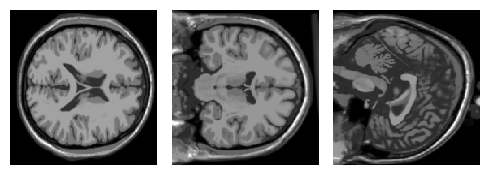

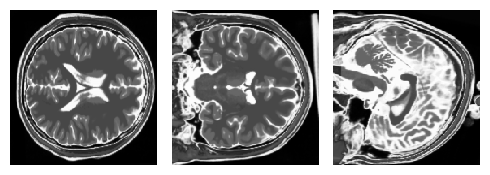

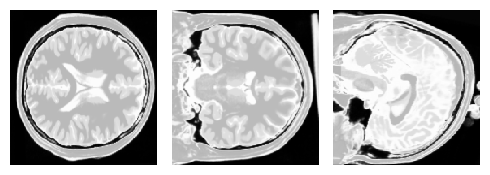

In [9]:
show_in_world_space(dat)

### INSPECT REGISTRATION COST FUNCTION

Now, let's inspect the cost function's behaviour as we keep one image fixed and move the second image.
Feel free to test the different options below

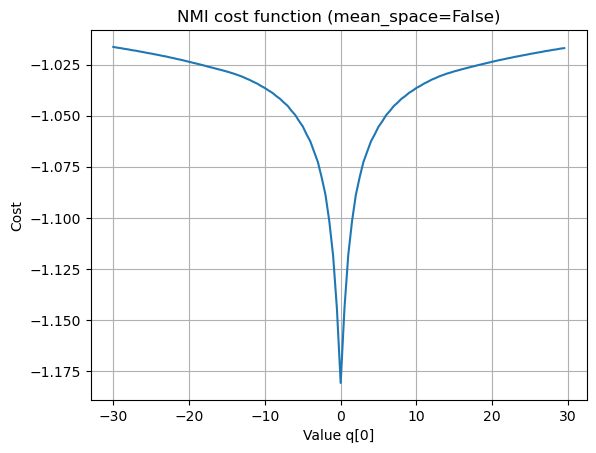

In [10]:
cost_fun = 'nmi'    # ['nmi', 'mi', 'ncc' ,'ecc' ,'njtv', 'jtv']
mean_space = False  # Only available for 'njtv' cost function (as groupwise)
samp = 2            # Level of sub-sampling
ix_par = 0          # What parameter in the affine transformation to modify (0, ..., 11)
x_mn_mx = 30        # Min/max value of parameter
x_step = 0.5        # Step-size of parameter

_test_cost([d[0] for d in dat[:2]], [d[1] for d in dat[:2]],
    ix_par=ix_par, cost_fun=cost_fun, mean_space=mean_space, samp=samp,
    x_mn_mx=x_mn_mx, x_step=x_step)

### CREATE RIGIDLY REALIGNED IMAGES

Next, we will rigidly realign all of the input scans by modifying their affine matrices.

In [11]:
dat = random2affine(dat)

Let's have a look at the realigned images

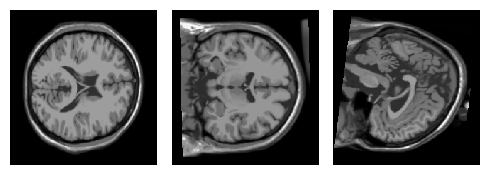

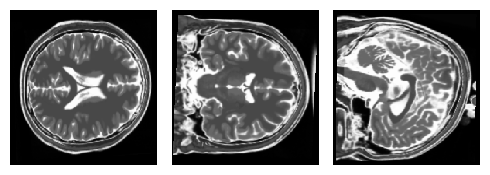

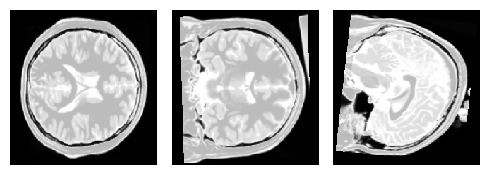

In [12]:
show_in_world_space(dat)

### PAIRWISE REGISTRAITON

We will now align the images using pairwise registration by keeping one of
the images fixed and registering
all other images to this fixed target image

In [13]:
# Parameters
cost_fun = 'nmi'  # The normalised mutual information cost
fix = 0           # Set the first image to the fixed one (remember, there are three in total)
samp = (4, 2)     # Use the default sub-sampling scheme (speeds up the registration)

# Do registration
dat_aligned = affine_align(dat, device=device, cost_fun=cost_fun,
                           samp=samp)[0]

Let's look at the pairwise registration result

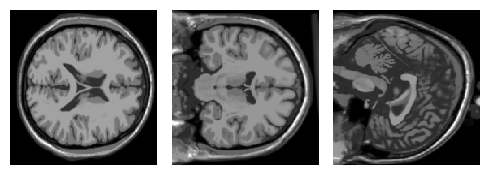

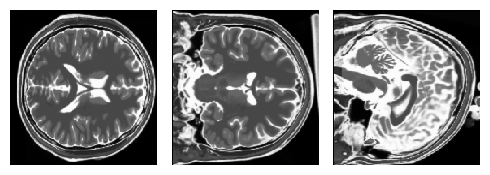

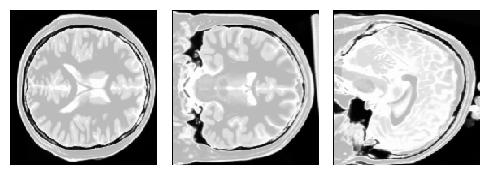

In [14]:
show_dat(dat_aligned)

### GROUPWISE REGISTRAITON

Finally, we will align the images using groupwise registration where the cost function optimiser over all images
at the same time. This is done using the Normalised Joint Total Variation (NJTV) cost function

In [15]:
# Parameters
cost_fun = 'njtv'  # Normalised joint total variation
mean_space = True  # Optimise a mean-space fit
samp = (4, 2)      # Use the default sub-sampling scheme (speeds up the registration)

# Do registration
dat_aligned = affine_align(dat, device=device, cost_fun=cost_fun,
                           samp=samp, mean_space=mean_space)[0]

Let's look at the groupwise registration result

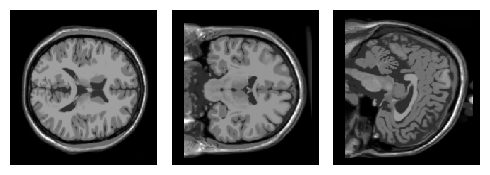

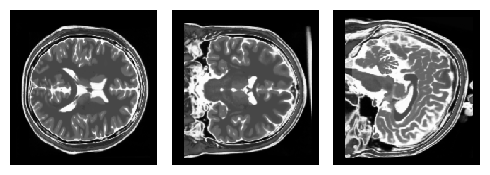

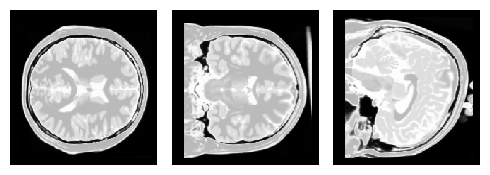

In [16]:
show_dat(dat_aligned)